In [120]:
import torch
from pygel3d import hmesh, graph, jupyter_display as jd
import numpy as np
import pymde
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.spatial import KDTree

import importlib
import helper_functions as hf 
importlib.reload(hf)

<module 'helper_functions' from 'e:\\GIT\\Bachelor\\PyMDE\\helper_functions.py'>

# Importing points

In [121]:
lim = 2000

mnist = pymde.datasets.MNIST()

embedded_tensor = torch.load("tensor.pt")
lim_embedded_tensor = embedded_tensor[:lim]

embedded_numpy = embedded_tensor.numpy()
lim_embedded_numpy = embedded_numpy[:lim]

non_embedded_numpy = np.array(mnist.data)
non_embedded_numpy = non_embedded_numpy.astype("float")
lim_non_embedded_numpy = non_embedded_numpy[:lim]

arr = lim_non_embedded_numpy
labels = mnist.attributes["digits"][:lim]

May 04 04:33:27 PM: Loading cached dataset.


# Plotting embedding, to see data according to limit

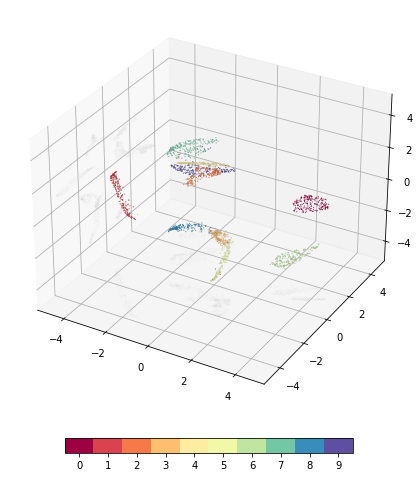

In [122]:
pymde.plot(lim_embedded_tensor,
           color_by=labels,
        #    marker_size = 10
)

# Creating pygel graph
Graph is created from pygel mesh, as only the mesh class allows for passing points as input

In [123]:
m = hmesh.Manifold().from_points(lim_embedded_numpy)

m.cleanup() # Just quick note. This resets node_ids. These should correspond to data ids, but do proceed with caution

# Creating graph from mesh
g = graph.from_mesh(m)
jd.display(g)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(0,0,0)', 'width': 1},
 …

# Creating distance matrix, for each point to each other point. 
There is probably a more efficient solution in storing, which could be explored later.

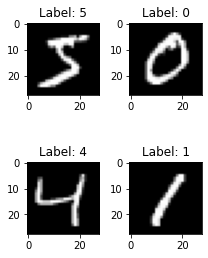

In [124]:
# Plotting mnist images
rows, cols = 2, 2
arr = lim_non_embedded_numpy

# plotting
fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols, 2*rows))
for i in range(rows*cols):
    ax = axes[i//cols, i%cols]
    ax.imshow(arr[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {labels[i]}")
plt.tight_layout()
plt.show()

In [125]:
# Checking if array is symmetric
# dist_matrix = hf.create_dist_matrix(arr)
dist_matrix = hf.create_dist_matrix(arr)
print("\n", np.allclose(dist_matrix.transpose(), dist_matrix))

100%|██████████| 2000/2000 [00:15<00:00, 126.02it/s]
 True



In [126]:
# print(arr[0])

# Distance Problem
## Might be usefull later 

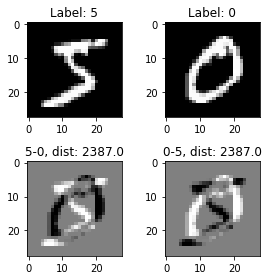

In [127]:
# Example of distance problem

fig, axes = plt.subplots(2, 2, figsize=(4, 4))
ax00 = axes[0,0]
ax00.imshow((arr[0]).reshape(28, 28), cmap="gray")
ax00.set_title("Label: 5")

ax01 = axes[0,1]
ax01.imshow((arr[1]).reshape(28, 28), cmap="gray")
ax01.set_title("Label: 0")

ax1 = axes[1,0]
ax1.imshow((arr[0] - arr[1]).reshape(28, 28), cmap="gray")
dist1 = np.linalg.norm(arr[0] - arr[1])
ax1.set_title(f"5-0, dist: {dist1//1}")

ax2 = axes[1,1]
ax2.imshow((arr[1] - arr[0]).reshape(28, 28), cmap="gray")
dist2 = np.linalg.norm(arr[1] - arr[0])
ax2.set_title(f"0-5, dist: {dist2//1}")
plt.tight_layout()
plt.show()

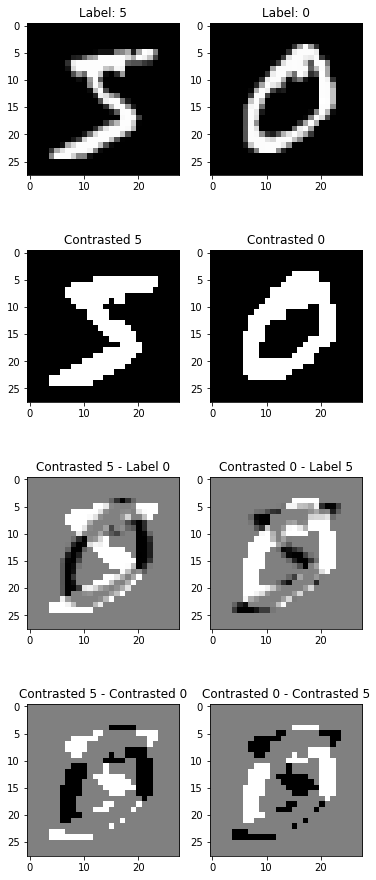

In [128]:
# Possible fix of problem, where all pixels are very saturated
t_arr = np.copy(arr)
vecs = [t_arr[0], t_arr[1]]

sat1 = np.copy(t_arr[0])
sat1[sat1 > 0] = 255
sat2 = np.copy(t_arr[1])
sat2[sat2 > 0] = 255

vecs.extend([sat1, sat2])

dist1 = sat1 - t_arr[1]
dist2 = sat2 - t_arr[0]

vecs.extend([dist1, dist2])

sat_dist1 = sat1 - sat2
sat_dist2 = sat2 - sat1

vecs.extend([sat_dist1, sat_dist2])

rows = len(vecs) // 2
cols = 2

titles = ["Label: 5", "Label: 0", "Contrasted 5", "Contrasted 0", "Contrasted 5 - Label 0", "Contrasted 0 - Label 5", "Contrasted 5 - Contrasted 0", "Contrasted 0 - Contrasted 5"]

# plotting
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 4*rows))
for i in range(rows*cols):
    ax = axes[i//cols, i%cols]
    ax.imshow(vecs[i].reshape(28, 28), cmap="gray")
    ax.set_title(titles[i])
plt.show()


# Looking at the distances gained

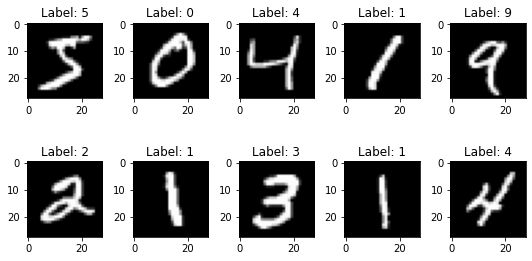

In [129]:
import seaborn as sns
import pandas as pd

def show_mnist_numbers(data, labels):
    # Plotting mnist images
    rows, cols = max(1, len(data)//5), 5
    arr = data
    # plotting
    fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols, 2*rows))
    for i in range(len(data)):
        if rows > 1:
            ax = axes[i//cols, i%cols]
        else:
            ax = axes[i%cols]
        ax.imshow(arr[i].reshape(28, 28), cmap="gray")
        ax.set_title(f"Label: {labels[i]}")
    plt.tight_layout()
    plt.show()

arr = np.copy(lim_non_embedded_numpy)
show_mnist_numbers(arr[:10], labels[:10])

# Heatmaps for minimum and average distance between labels

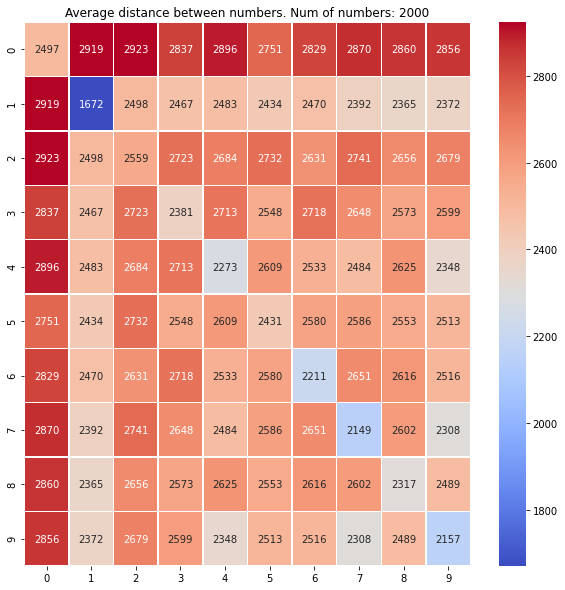

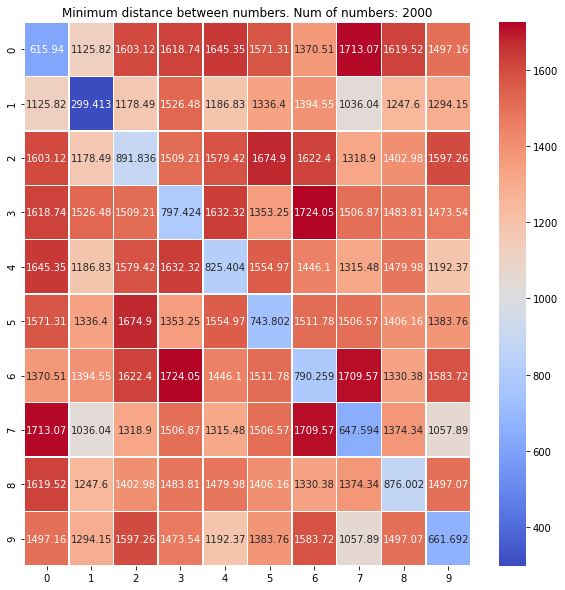

In [130]:
dist = dist_matrix

avg_heat_data = np.zeros((10, 10), dtype=float) 
for i in range(10): # Because 10 different numbers
    row_dist_idx = np.where(labels==i)[0]
    try:
        row_dist_data = dist[row_dist_idx]    
    except:
        print(row_dist_idx)
    for j in range(10):
        col_dist_idx = np.where(labels==j)[0]
        col_dist_data = row_dist_data[:,col_dist_idx]
        avg_heat_data[i, j] = np.mean(col_dist_data)//1

min_heat_data = np.zeros((10, 10), dtype=float)
for i in range(10): # Because 10 different numbers
    row_dist_idx = np.where(labels==i)[0]
    row_dist_data = dist[row_dist_idx]
    for j in range(10):
        col_dist_idx = np.where(labels==j)[0]
        col_dist_data = row_dist_data[:,col_dist_idx]
        without_zero = col_dist_data[col_dist_data != 0]
        min_heat_data[i][j] = np.min(without_zero)

fig, heatmap = plt.subplots(figsize=(10, 10))
heatmap = sns.heatmap(avg_heat_data, linewidths=.5, annot=True, cmap='coolwarm' ,fmt="g").set_title(f"Average distance between numbers. Num of numbers: {len(arr)}")

fig, heatmap = plt.subplots(figsize=(10, 10))
heatmap = sns.heatmap(min_heat_data, linewidths=.5, annot=True, cmap='coolwarm' ,fmt="g").set_title(f"Minimum distance between numbers. Num of numbers: {len(arr)}")

In [131]:
# np arr test
test_arr = np.zeros((5, 3))
print("Whole: \n", test_arr, "\n")
print("Row: ", test_arr[0])

Whole: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] 

Row:  [0. 0. 0.]


# Creating graph from nearest neighbours

In [132]:
# Argpartition test
np.random.seed(1)
org = np.random.rand(10)*100//1
test_a = np.copy(org)
print(f"Array of random vals {test_a}")
k = 5
idx = np.argpartition(test_a, k)
print(f"ids in non_sorted order: {test_a[idx[:k]]} for k={k} elements")
print(f"Arrays equal: {np.array_equal(org, test_a)}")

Array of random vals [41. 72.  0. 30. 14.  9. 18. 34. 39. 53.]
ids in non_sorted order: [ 9. 18.  0. 14. 30.] for k=5 elements
Arrays equal: True


In [133]:
import importlib
import helper_functions as hf
importlib.reload(hf)

# Disconnecting graph
hf.disconnect_graph(g)
pos = g.positions()

for n, ppos in tqdm(zip(g.nodes(), lim_embedded_numpy)):
    pos[n] = ppos

hf.connect_k_closest_points(g, dist_matrix, k=1, max_dist=1700)

2000it [00:00, 800210.63it/s]


In [134]:
# Counting edges
unique = set([])
sum = 0
for n in g.nodes():
    neighbours = set(g.neighbors(n, mode="e"))
    sum += len(neighbours)
    unique |= neighbours
print(sum)
print(len(unique))

2718
1359


In [135]:
jd.display(g)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(0,0,0)', 'width': 1},
 …

# Skeletonizing graph

In [136]:
skeleton = graph.LS_skeleton(g)
jd.display(skeleton)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(0,0,0)', 'width': 1},
 …

# Comparing number of edges

In [137]:
def print_change(g, skel):
    g_edges, skel_edges = set([]), set([])
    for n in g.nodes():
        g_edges |= set([x for x in g.neighbors(n, mode="e")])
    for n in skeleton.nodes():
        skel_edges |= set([x for x in skeleton.neighbors(n, mode="e")])

    reduction = len(g_edges) - len(skel_edges)
    percentage = 100 * (len(g_edges) - len(skel_edges)) // len(g_edges)
    print(f"Num g: {len(g_edges)}. Num skeleton: {len(skel_edges)} Reduction: {reduction}. In percent: {percentage}%")

print_change(g, skeleton)

# for i in range(1, 6):
#     hf.disconnect_graph(g)
#     hf.connect_k_closest_points(g, dist_matrix, k=i)
#     skel = graph.LS_skeleton(g)
#     print_change(g, skel)

Num g: 1359. Num skeleton: 1359 Reduction: 0. In percent: 0%


# Rediscovering Labels

In [138]:
tree = KDTree(lim_embedded_numpy)
skeleton.cleanup()

skel_labels = np.zeros(len(skeleton.nodes()))
skel_non_embed = np.zeros((len(skeleton.nodes()), 784))

pos = skeleton.positions()
for n in skeleton.nodes():
    dist, idx = tree.query(pos[n])
    skel_labels[n] = labels[idx]
    skel_non_embed[n] = lim_non_embedded_numpy[idx]

cnt = []
for i in range(10):
    cnt.append( len(skel_labels[skel_labels == i]) )

print(",".join(str((f'{i}', cnt[i])) for i in range(len(cnt))))


('0', 175),('1', 218),('2', 140),('3', 157),('4', 198),('5', 153),('6', 186),('7', 215),('8', 141),('9', 194)


# Classifying "unknown" labels 

In [139]:
importlib.reload(hf)
test_size = 1000
Y_test = mnist.attributes["digits"][lim:lim+test_size]
x_test = non_embedded_numpy[lim:lim+test_size]
 
guess = list()
for idx, val in tqdm(enumerate(x_test)):
    dist, nearest_idx = hf.nearest_neighbours(skel_non_embed, val)
    guess.append((skel_labels[nearest_idx], Y_test[idx]))

tru, fal = 0, 0
data = data = np.zeros((10, 4))
for gue in guess:
    if gue[0] == gue[1]:
        
        tru += 1

    else:
        fal += 1

accuracy = (tru)/(tru+fal)
print("\n", accuracy)

1000it [00:06, 154.59it/s]
 0.907

